In [1]:
from src.phishIRISData import PhishIRISData
import matplotlib.pyplot as plt
import numpy as np
import cv2

data = PhishIRISData().get_data()

In [2]:
from sklearn.model_selection import train_test_split

images_training, images_testing, labels_training, labels_testing = train_test_split(data.imgs, data.labels, test_size=0.2, random_state=42)

# images_training, labels_training = train
# images_testing, labels_testing = test

In [3]:
def read_bw_images(img_paths):
    """
    Read images and convert them to black and white
    :param img_paths:
    :return: list of black and white images
    """
    return [
        cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
        if len(cv2.imread(img_path).shape) == 3
        else cv2.imread(img_path)
        for img_path in img_paths
    ]

In [4]:
bw_images = []
for img_path in images_training:
    # if RGB, transform into grayscale
    img = cv2.imread(img_path)
    if len(img.shape) == 3:
        bw_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        # if grayscale, do not transform
        bw_images.append(img)

In [5]:
def clean_descriptors(
    keypoints: list[cv2.KeyPoint], descriptors: list[np.ndarray]
) -> tuple[list[cv2.KeyPoint], list[np.ndarray]]:
    print(f"len before: {len(descriptors)}")
    # initialize list to store idx values of records to drop
    to_drop = []
    for i, img_descriptors in enumerate(descriptors):
        # if there are no descriptors, add record idx to drop list
        if img_descriptors is None:
            to_drop.append(i)

    print(f"indexes: {to_drop}")
    # delete from list in reverse order
    for i in sorted(to_drop, reverse=True):
        del descriptors[i], keypoints[i]

    print(f"len after: {len(descriptors)}")
    return keypoints, descriptors

In [6]:
def run_sift(images, clean=True) -> tuple[list[cv2.KeyPoint], list[np.ndarray]]:
    """
    Run SIFT on a list of black and white images
    :param images:
    :return: list of keypoints and descriptors
    """
    sift = cv2.SIFT_create()
    keypoints_agg: list[cv2.KeyPoint] = []
    descriptors_agg: list[np.ndarray] = []
    for img in images:
        # extract keypoints and descriptors for each image
        img_keypoints, img_descriptors = sift.detectAndCompute(img, None)
        keypoints_agg.append(img_keypoints)
        descriptors_agg.append(img_descriptors)

    return clean_descriptors(
        keypoints_agg, descriptors_agg
    ) if clean else keypoints_agg, descriptors_agg

In [7]:
test_bw_images = read_bw_images(images_testing)
keypoints_t, descriptors_t = run_sift(test_bw_images)

len before: 183
indexes: []
len after: 183


In [8]:
# defining feature extractor that we want to use (SIFT)
extractor = cv2.SIFT_create()

# initialize lists where we will store *all* keypoints and descriptors
keypoints = []
descriptors = []

for img in bw_images:
    # extract keypoints and descriptors for each image
    img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
    keypoints.append(img_keypoints)
    descriptors.append(img_descriptors)

In [9]:
print(f"len before: {len(descriptors)}")
# initialize list to store idx values of records to drop
to_drop = []
for i, img_descriptors in enumerate(descriptors):
    # if there are no descriptors, add record idx to drop list
    if img_descriptors is None:
        to_drop.append(i)

print(f"indexes: {to_drop}")
# delete from list in reverse order
for i in sorted(to_drop, reverse=True):
    del descriptors[i], keypoints[i]

print(f"len after: {len(descriptors)}")

len before: 730
indexes: []
len after: 730


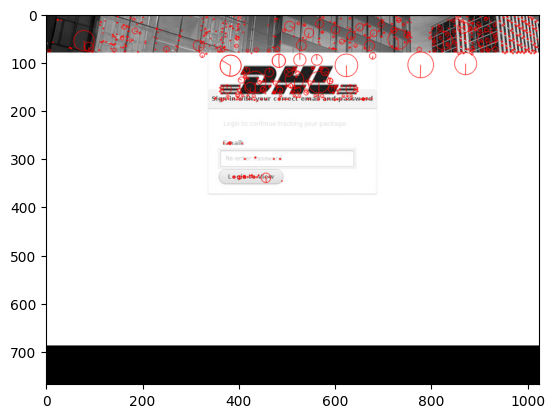

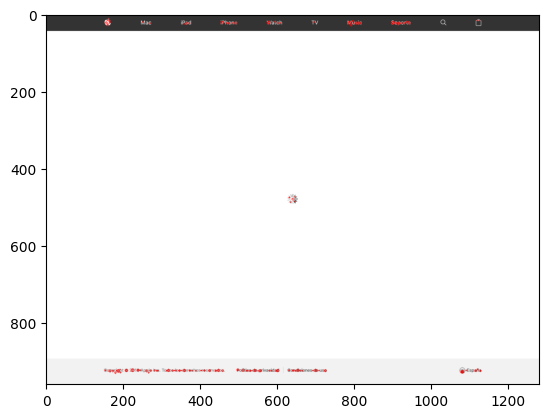

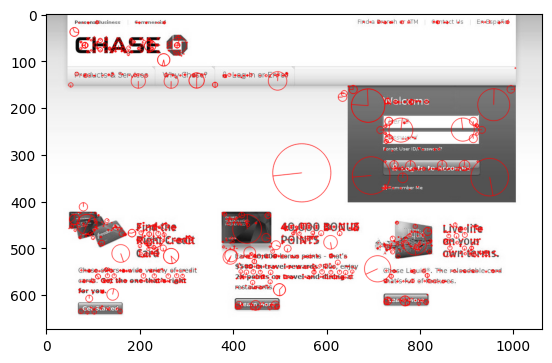

In [10]:
output_image = []
for x in range(3):
    output_image.append(
        cv2.drawKeypoints(
            bw_images[x],
            keypoints[x],
            0,
            (255, 0, 0),
            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
        )
    )
    plt.imshow(output_image[x], cmap="gray")
    plt.show()

In [11]:
# select the same numbers in each run
np.random.seed(42)
# select 1000 random image index values
sample_idx = np.random.randint(0, len(images_training) + 1, 1000).tolist()
len(sample_idx)

1000

In [12]:
# extract the sample from descriptors
# (we don't need keypoints)
descriptors_sample = []

for n in sample_idx:
    descriptors_sample.append(np.array(descriptors[n]))

In [13]:
all_descriptors = []
# extract image descriptor lists
for img_descriptors in descriptors_sample:
    # extract specific descriptors within the image
    for descriptor in img_descriptors:
        all_descriptors.append(descriptor)
# convert to single numpy array
all_descriptors = np.stack(all_descriptors)

In [14]:
# check the shape
all_descriptors.shape

(1918148, 128)

In [15]:
# we can count the number of descriptors contained in descriptors to confirm
count = []
for img_descriptors in descriptors_sample:
    count.append(len(img_descriptors))
# here we can see the number of descriptors for the first five images
print(f"first five: {count[:5]}")
# and if we sum them all, we should see the 39893 from before
print(f"count all: {sum(count)}")

first five: [9267, 1301, 2453, 2347, 219]
count all: 1918148


In [16]:
# perform k-means clustering to build the codebook
from scipy.cluster.vq import kmeans

k = 200
iters = 1
codebook, variance = kmeans(all_descriptors, k, iters)

In [17]:
import joblib

# save number of clusters and codebook
# Joblib dumps Python object into one file
joblib.dump((k, codebook), "bovw-codebook.pkl", compress=3)

['bovw-codebook.pkl']

In [18]:
# load the visual features, number of clusters, and codebook
k, codebook = joblib.load("bovw-codebook.pkl")

# Vector Quantization

In [19]:
# vector quantization
from scipy.cluster.vq import vq

visual_words = []
for img_descriptors in descriptors:
    # for each image, map each descriptor to the nearest codebook entry
    img_visual_words, distance = vq(img_descriptors, codebook)
    visual_words.append(img_visual_words)

In [20]:
def get_visual_words(descriptors, codebook):
    visual_words = []
    for img_descriptors in descriptors:
        # for each image, map each descriptor to the nearest codebook entry
        img_visual_words, distance = vq(img_descriptors, codebook)
        visual_words.append(img_visual_words)
    return visual_words

In [21]:
def get_frequency_vectors(visual_words, k):
    frequency_vectors = []
    for img_visual_words in visual_words:
        # create a frequency vector for each image
        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        frequency_vectors.append(img_frequency_vector)
    return np.stack(frequency_vectors)

In [22]:
visual_words_t = get_visual_words(descriptors_t, codebook)
frequency_vectors_t = get_frequency_vectors(visual_words_t, k)

---

In [23]:
# let's see what the visual words look like for image 0
visual_words[0][:5], len(visual_words[0])

(array([ 39, 112, 123, 123, 123], dtype=int32), 816)

In [24]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [25]:
frequency_vectors.shape

(730, 200)

In [26]:
# the centroid that represents visual word 84 is of dimensionality...
codebook[79].shape  # (all have the same dimensionality)

(128,)

In [27]:
frequency_vectors = []
for img_visual_words in visual_words:
    # create a frequency vector for each image
    img_frequency_vector = np.zeros(k)
    for word in img_visual_words:
        img_frequency_vector[word] += 1
    frequency_vectors.append(img_frequency_vector)
# stack together in numpy array
frequency_vectors = np.stack(frequency_vectors)

In [28]:
frequency_vectors.shape

(730, 200)

In [29]:
# we know from above that ids 84, 22, 45, and 172 appear in image 0
for i in [156, 187, 6, 27, 49]:
    print(f"{i}: {frequency_vectors[0][i]}")

156: 8.0
187: 26.0
6: 7.0
27: 2.0
49: 2.0


In [30]:
frequency_vectors[0][:20]

array([23.,  8., 12.,  2.,  1., 12.,  7.,  2.,  0.,  2.,  3.,  2.,  2.,
        2.,  1.,  4.,  4.,  3.,  3.,  8.])

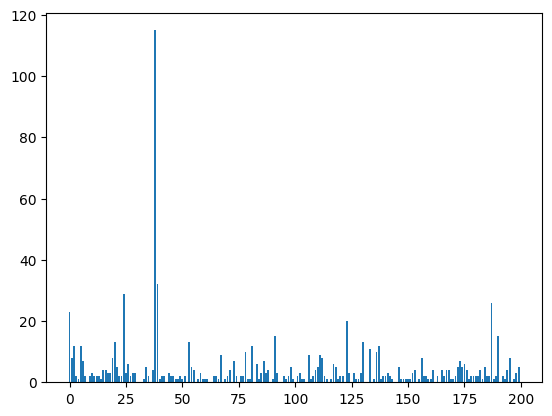

In [31]:
plt.bar(list(range(k)), frequency_vectors[0])
plt.show()

# Tf-Idf

In [32]:
# N is the number of images, i.e. the size of the dataset
N = len(data.imgs)

# df is the number of images that a visual word appears in
# we calculate it by counting non-zero values as 1 and summing
df = np.sum(frequency_vectors > 0, axis=0)

In [33]:
df.shape, df[:5]

((200,), array([708, 616, 706, 628, 479]))

In [34]:
idf = np.log(N / df)
idf.shape, idf[:5]

((200,), array([0.25429179, 0.39348892, 0.25712064, 0.37419571, 0.64503528]))

In [35]:
tfidf = frequency_vectors * idf
tfidf.shape, tfidf[0][:5]

((730, 200),
 array([5.8487111 , 3.14791134, 3.08544772, 0.74839143, 0.64503528]))

In [36]:
def get_tfidf(frequency_vectors):
    N = len(frequency_vectors)
    df = np.sum(frequency_vectors > 0, axis=0)
    print(df.shape, df[:5])
    idf = np.log(N / df)
    print(idf.shape, idf[:5])
    print(tfidf.shape, tfidf[0][:5])
    return frequency_vectors * idf

In [37]:
tfidf_t = get_tfidf(frequency_vectors_t)

(200,) [181 164 180 166 130]
(200,) [0.01098912 0.10961973 0.0165293  0.09749836 0.3419517 ]
(730, 200) [5.8487111  3.14791134 3.08544772 0.74839143 0.64503528]


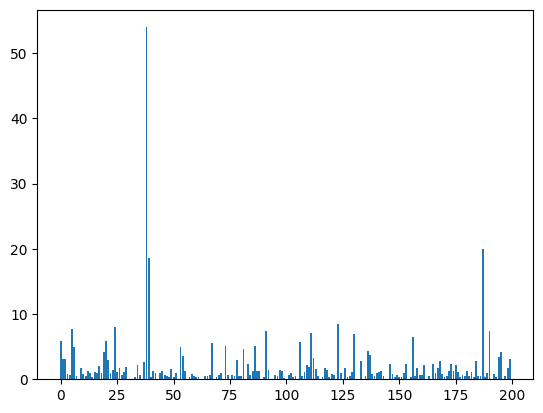

In [38]:
plt.bar(list(range(k)), tfidf[0])
plt.show()

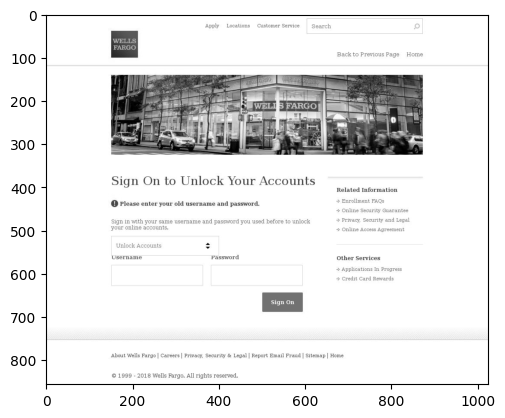

In [39]:
search_i = 333

plt.imshow(bw_images[search_i], cmap="gray")
plt.show()

In [40]:
# cosine similarity
from numpy.linalg import norm

a = tfidf[search_i]
b = tfidf  # set search space to the full sample

cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))
print("Min cosine similarity:", round(np.min(cosine_similarity), 1))
print("Max cosine similarity:", np.max(cosine_similarity))

Min cosine similarity: 0.1
Max cosine similarity: 0.9999999999999999


In [41]:
cosine_similarity.shape

(730,)

In [42]:
cosine_similarity

array([0.46924472, 0.37175325, 0.56196642, 0.45307643, 0.56304802,
       0.74821159, 0.70217413, 0.73554557, 0.53129449, 0.48776421,
       0.27575785, 0.38487259, 0.38652109, 0.32900775, 0.67755235,
       0.35861873, 0.4723876 , 0.4446574 , 0.31218702, 0.4155767 ,
       0.50785568, 0.43626401, 0.72469784, 0.65763005, 0.37097354,
       0.43494561, 0.54431137, 0.57249335, 0.74821247, 0.63690851,
       0.42338687, 0.45492172, 0.33689525, 0.64651339, 0.7409358 ,
       0.24613573, 0.57565712, 0.49773421, 0.28052778, 0.60649798,
       0.66039333, 0.39169431, 0.42514937, 0.31308329, 0.4510348 ,
       0.39541794, 0.67017018, 0.38234109, 0.69476498, 0.40990244,
       0.59278632, 0.44783262, 0.48988759, 0.47797219, 0.40312513,
       0.54740826, 0.34763707, 0.38628893, 0.5419191 , 0.73381756,
       0.45849289, 0.45496213, 0.70999755, 0.39745126, 0.3725127 ,
       0.52516346, 0.38830824, 0.80059187, 0.29348058, 0.69476498,
       0.4119674 , 0.38961439, 0.66194483, 0.84517927, 0.82634

In [43]:
top_k = 5
idx = np.argsort(-cosine_similarity)[:top_k]
idx

array([333, 239, 217, 244, 101])

In [44]:
cosine_similarity[idx[0]]

0.9999999999999999

333: 1.0


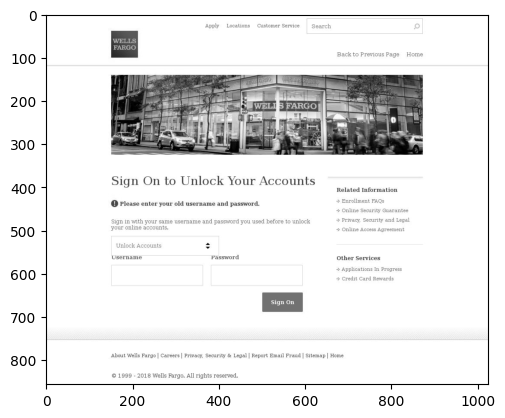

239: 0.9958


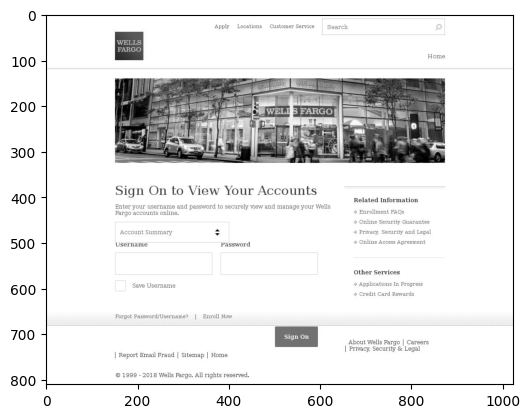

217: 0.8765


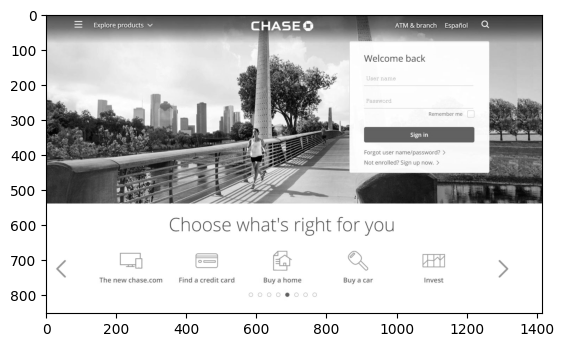

244: 0.8602


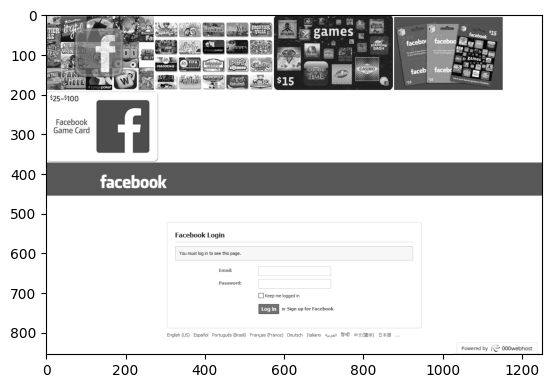

101: 0.8602


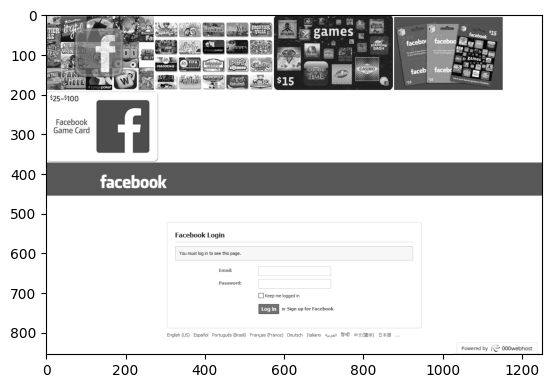

In [45]:
for i in idx:
    print(f"{i}: {round(cosine_similarity[i], 4)}")
    plt.imshow(bw_images[i], cmap="gray")
    plt.show()

In [46]:
def search(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(bw_images[i], cmap="gray")
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf[i]
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap="gray")
        plt.show()
    return idx

In [47]:
def search_test(i: int, top_k: int = 5):
    print("Search image:")
    # show the search image
    plt.imshow(test_bw_images[i], cmap="gray")
    plt.show()
    print("-----------------------------------------------------")
    # get search image vector
    a = tfidf_t[i]
    b = tfidf
    # get the cosine distance for the search image `a`
    cosine_similarity = np.dot(a, b.T) / (norm(a) * norm(b, axis=1))
    # get the top k indices for most similar vecs
    idx = np.argsort(-cosine_similarity)[:top_k]
    # display the results
    for i in idx:
        print(f"{i}: {round(cosine_similarity[i], 4)}")
        plt.imshow(bw_images[i], cmap="gray")
        plt.show()

    return idx

Search image:


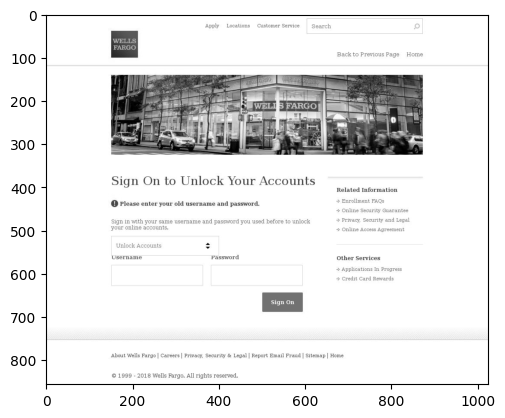

-----------------------------------------------------
333: 1.0


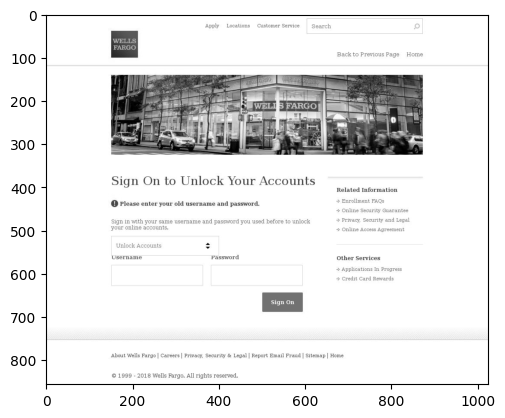

239: 0.9958


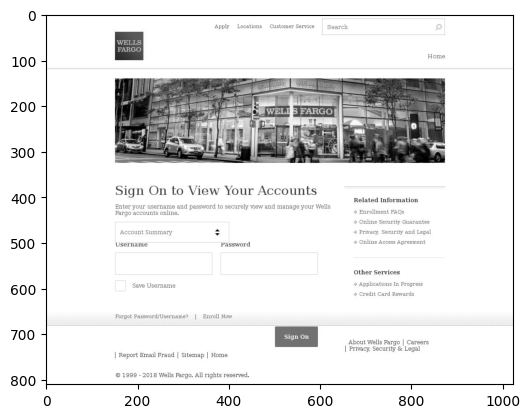

217: 0.8765


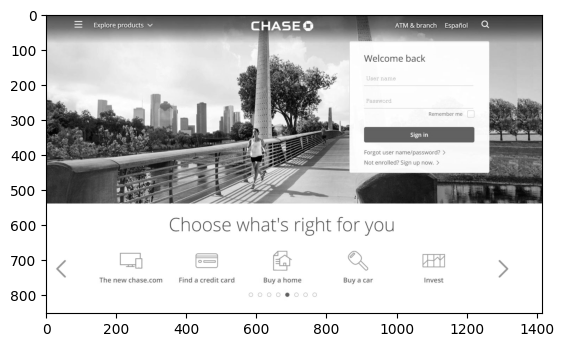

244: 0.8602


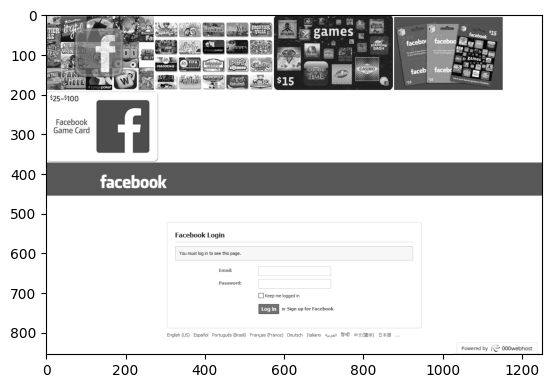

101: 0.8602


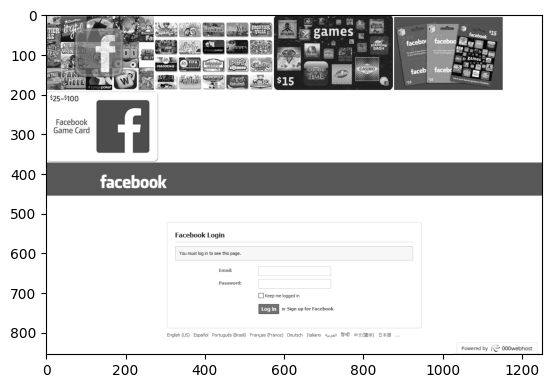

array([333, 239, 217, 244, 101])

In [48]:
search(333)